In [53]:
import numpy as np
import matplotlib.pyplot as plt

In [54]:
import sys
sys.path.insert(0, "/home/tfioratti/git/stockora/")
from stockora.shadow_clone import parallelize

In [55]:
# All runs reuse the same J, I_vec, x0, v0 for fair comparison across g.

import numpy as np
import matplotlib.pyplot as plt


def phi_tanh(x):
    return np.tanh(x)

def dphi_tanh(x):
    t = np.tanh(x)
    return 1.0 - t*t


def make_J(N, seed_J=0):
    rng = np.random.RandomState(seed_J)
    return rng.randn(N, N) / np.sqrt(N)

def make_bias(N, sigma_I=0.03, seed_I=1):
    rng = np.random.RandomState(seed_I)
    return sigma_I * rng.randn(N)

def make_x0(N, scale=0.1, seed_x0=2):
    rng = np.random.RandomState(seed_x0)
    return scale * rng.randn(N)

def make_v0(N, seed_v0=3):
    rng = np.random.RandomState(seed_v0)
    v = rng.randn(N)
    return v / (np.linalg.norm(v) + 1e-32)


def step(x, J, g, tau, dt, I_vec):
    ph = phi_tanh(x)
    return x + dt * ((-x/2 + g/4 * (J @ ph) + I_vec) / tau)

def compute_trajectory(J, I_vec, g, tau, dt, T, warmup, x0, record_stride=1):
    steps_warm = int(np.round(warmup / dt))
    steps_sim  = int(np.round(T / dt))
    x = np.copy(x0)
    t = 0.0

    # warmup
    for _ in range(steps_warm):
        x = step(x, J, g, tau, dt, I_vec)
        t += dt

    # simulate
    S  = steps_sim // record_stride
    Xs = np.empty((S, J.shape[0]))
    ts = np.empty(S)
    k  = 0
    for s in range(steps_sim):
        x = step(x, J, g, tau, dt, I_vec)
        t += dt
        if (s + 1) % record_stride == 0:
            Xs[k] = x
            ts[k] = t
            k += 1
    return Xs, ts

def compute_autocorr(Xs, max_lag=2000, stride=1):
    X = Xs - Xs.mean(axis=0, keepdims=True)
    T = X.shape[0]
    L = max_lag // stride + 1
    ac = np.zeros(L)
    denom = (X**2).sum(axis=0).mean()
    for ell in range(L):
        lag = ell * stride
        if lag >= T:
            break
        prod = (X[lag:] * X[:T-lag]).sum(axis=0).mean()
        ac[ell] = prod / denom
    lags = np.arange(L) * stride
    return ac, lags

def compute_lyapunov(J, I_vec, g, tau, dt, T, warmup, x0, v0, reorth_every=10, eps0=1e-7):
    # warmup
    steps_warm = int(np.round(warmup / dt))
    x = np.copy(x0)
    v = np.copy(v0)
    for _ in range(steps_warm):
        x = step(x, J, g, tau, dt, I_vec)

    steps = int(np.round(T / dt))
    accum = 0.0
    count = 0
    for s in range(steps):
        x = step(x, J, g, tau, dt, I_vec)

        dph = dphi_tanh(x)
        w = J @ (dph * v) /4
        dv = (-v/2 + g * w) / tau
        v  = v + dt * dv

        if (s + 1) % reorth_every == 0:
            norm_v = np.linalg.norm(v) + 1e-32
            accum += np.log(norm_v / eps0)
            count += 1
            v = (eps0 / norm_v) * v

    return accum / (count * reorth_every * dt) if count > 0 else float('nan')


def plot_trajectories(ts, Xs, neuron_idx=None, max_traces=5, title=None):
    if neuron_idx is None:
        neuron_idx = np.arange(min(max_traces, Xs.shape[1]))
    plt.figure(figsize=(8,4.5))
    for i in neuron_idx:
        plt.plot(ts, Xs[:, i], label=f"unit {i}")
    plt.xlabel("time")
    plt.ylabel("x_i(t)")
    if title:
        plt.title(title)
    plt.grid(True, alpha=0.3)
    if len(neuron_idx) <= 10:
        plt.legend()
    plt.show()

def plot_lyapunov(g_vals, lam_vals, title=None):
    plt.figure(figsize=(8,4.5))
    plt.plot(g_vals, lam_vals, marker="o")
    plt.axhline(0.0, linestyle="--")
    plt.xlabel("g")
    plt.ylabel("Largest Lyapunov exponent (1/time)")
    if title:
        plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.show()


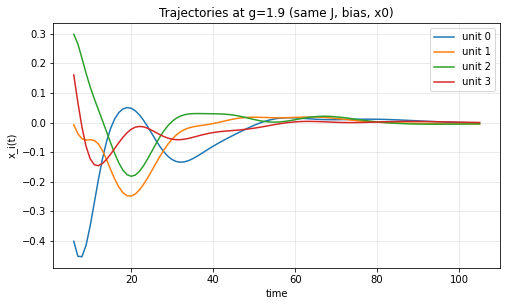

In [58]:
N = 1000
tau = 1.0
dt = 1
sigma_I = 0

J = make_J(N, seed_J=0)
I_vec = make_bias(N, sigma_I=sigma_I, seed_I=1)
x0 = make_x0(N, scale=1, seed_x0=2)
v0 = make_v0(N, seed_v0=3)


g_traj = 1.9
T = 100.0
warmup = 5.0
Xs, ts = compute_trajectory(J, I_vec, g_traj, tau, dt, T, warmup, x0, record_stride=1)
plot_trajectories(ts, Xs, max_traces=4, title=f"Trajectories at g={g_traj} (same J, bias, x0)")



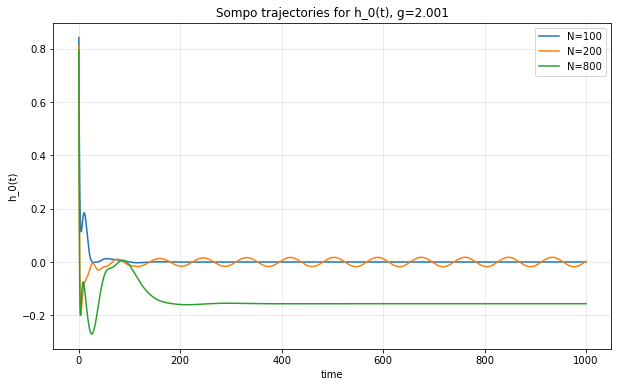

In [57]:
N_dim = [100, 200, 800]
dt = 0.1
g_traj = 2.001
T = 1000.0
warmup = 0
plt.figure(figsize=(10, 6))

for N in N_dim:
    sigma_I = 0

    J = make_J(N, seed_J=1)
    I_vec = make_bias(N, sigma_I=sigma_I, seed_I=1)
    x0 = make_x0(N, scale=0.5, seed_x0=3)

    Xs, ts = compute_trajectory(J, I_vec, g_traj, tau, dt, T, warmup, x0, record_stride=1)

    plt.plot(ts, Xs[:, 0], label=f"N={N}")

plt.xlabel("time")
plt.ylabel("h_0(t)")
plt.title(f"Sompo trajectories for h_0(t), g={g_traj}")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

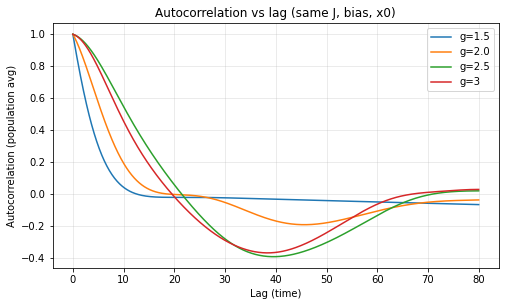

In [26]:
#AUTOCORRELATION PLOT
g_list = [1.5, 2.0, 2.5,3]
max_lag_steps = 800


plt.figure(figsize=(8,4.5))
for g in g_list:
    Xs_g, ts_g = compute_trajectory(J, I_vec, g, tau, dt, T, warmup, x0, record_stride=1)
    ac, lags = compute_autocorr(Xs_g, max_lag=max_lag_steps, stride=1)
    plt.plot(lags*dt, ac, label=f"g={g}")
plt.xlabel("Lag (time)")
plt.ylabel("Autocorrelation (population avg)")
plt.title("Autocorrelation vs lag (same J, bias, x0)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


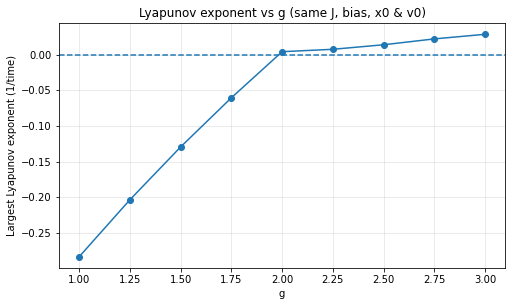

In [33]:
#MAX LYAPUNOV
N = 2000
tau = 1.0
dt = 1
sigma_I = 0

J = make_J(N, seed_J=0)
I_vec = make_bias(N, sigma_I=sigma_I, seed_I=1)
x0 = make_x0(N, scale=0.1, seed_x0=2)
v0 = make_v0(N, seed_v0=3)

g_vals = np.linspace(1, 3, 9)
lam_vals = []
for g in g_vals:
    lam = compute_lyapunov(J, I_vec, g, tau, dt, T=2000.0, warmup=250.0, x0=x0, v0=v0,
                           reorth_every=10, eps0=1e-7)
    lam_vals.append(lam)

plot_lyapunov(g_vals, lam_vals, title="Lyapunov exponent vs g (same J, bias, x0 & v0)")

Text(0, 0.5, 'Lyapunov')

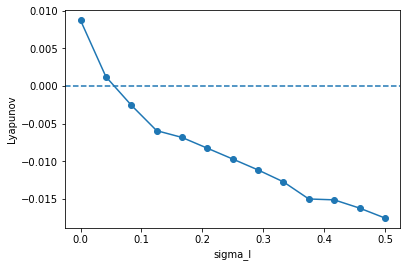

In [28]:
# direzione fissa del bias
rng = np.random.RandomState(123)
u = rng.randn(N); u /= np.linalg.norm(u)

sigma_grid = np.linspace(0.0, 0.5, 13)
g = 2.0

lam = []
phi_prime_avg = []
for sigma_I in sigma_grid:
    I_vec = sigma_I * u
    lam.append(compute_lyapunov(J, I_vec, g, tau, dt, T=2000.0, warmup=100.0,
                                x0=x0, v0=v0, reorth_every=10))

plt.figure(); plt.plot(sigma_grid, lam, marker='o'); plt.axhline(0, ls='--'); plt.xlabel('sigma_I'); plt.ylabel('Lyapunov')

In [59]:
N=4000; tau=1.0; dt=1
T=2000.0; warmup=250.0

def _split_seeds(seed_J: int):
    base = int(seed_J) & 0xFFFFFFFF
    return {
        'seed_x0':      (base + 1) & 0xFFFFFFFF,
        'seed_v0':      (base + 2) & 0xFFFFFFFF,
        'seed_biasdir': (base + 3) & 0xFFFFFFFF,
    }

def find_gc_job(job, *, N, tau, dt, T, warmup,
                g_lo=1.7, g_hi=5.0, tol=1e-3, max_iter=20):
  
    sigma_b = float(job['sigma_b'])
    seed_J  = int(job['seed_J'])

    J  = make_J(N, seed_J)
    seeds = _split_seeds(seed_J)
    x0 = make_x0(N, scale=0.1, seed_x0=seeds['seed_x0'])
    v0 = make_v0(N,seeds['seed_v0'])

    rng = np.random.RandomState(seeds['seed_biasdir'])
    u = rng.randn(N)
    u_dir = u / np.std(u)
    I_vec = sigma_b * u_dir

    lam_lo = compute_lyapunov(J, I_vec, g_lo, tau, dt, T, warmup, x0, v0)
    lam_hi = compute_lyapunov(J, I_vec, g_hi, tau, dt, T, warmup, x0, v0)

    if lam_lo >= 0:
        gc = g_lo
    elif lam_hi <= 0:
        gc = np.nan 
    else:
        lo, hi = g_lo, g_hi
        for _ in range(max_iter):
            mid = 0.5*(lo+hi)
            lam = compute_lyapunov(J, I_vec, mid, tau, dt, T, warmup, x0, v0)
            if lam > 0: hi = mid
            else:       lo = mid
            if hi - lo < tol:
                break
        gc = 0.5*(lo+hi)

    return {
        'seed_J': seed_J,
        'sigma_b': sigma_b,
        'g_c': float(gc),
    }


In [60]:
sigma_grid   = np.linspace(0, 0.5, 20)
seed_J_list  = list(range(24))  # p.es. 24 repliche su J

jobs = [{'seed_J': int(sJ), 'sigma_b': float(s)}
        for sJ in seed_J_list
        for s in sigma_grid]

results = parallelize(
    exec_func=find_gc_job,
    jobs=jobs,
    single_arg=True,
    exec_kwargs=dict(
        N=N, tau=tau, dt=dt, T=T, warmup=warmup,
        g_lo=1.7, g_hi=5.0, tol=1e-3, max_iter=10
    ),
    mode="slurm",
    wait_for_graph_execution=False,
    root_dir="/mnt/live/user/tfioratti/gc_parallel_J_sigma",
)


Graph tfioratti__gc_parallel_J_sigma posted. Follow the execution using the [grid view](https://srv006545.fr.cfm.fr:56006/graph/index.html#/manage/tfioratti__gc_parallel_J_sigma) or the [graph view](https://srv006545.fr.cfm.fr:56006/graph/index.html#/display/tfioratti__gc_parallel_J_sigma)

In [73]:
import json
from pathlib import Path
results_dir = Path("/mnt/live/user/tfioratti/gc_parallel_J_sigma/execution_results")

data_dict = {}

for result_file in results_dir.glob("*.json"):  
    with open(result_file, 'r') as file:
        data = json.load(file)
    tau_value = data  
    file_key = result_file.stem
    data_dict[file_key] = tau_value


In [74]:
seeds = sorted({v['seed_J'] for v in data_dict.values()})
sigma_b_values = sorted({v['sigma_b'] for v in data_dict.values()})

seed_index = {seed: i for i, seed in enumerate(seeds)}
sigma_b_index = {sigma: i for i, sigma in enumerate(sigma_b_values)}


g_c_array = np.empty((len(seeds), len(sigma_b_values)))

for item in data_dict.values():
    seed = item['seed_J']
    sigma_b = item['sigma_b']
    g_c = item['g_c']
    i = seed_index[seed]
    j = sigma_b_index[sigma_b]
    g_c_array[i, j] = g_c

g_c_empirical = np.mean(g_c_array, axis = 0)
err = np.std(g_c_array, axis = 0)/np.sqrt(len(seed_J_list))

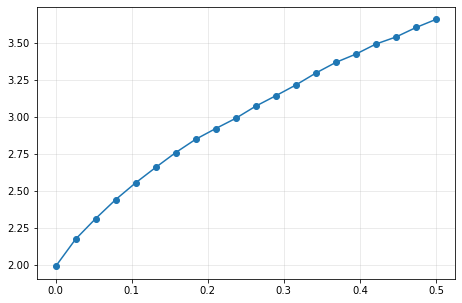

In [77]:
plt.figure(figsize=(7.5,5))
plt.plot(sigma_b_values, g_c_empirical, marker="o")
#plt.xlabel(r"Bias amplitude $sigma_I$ (fixed direction, per-neuron std)")
#plt.ylabel(r"Critical gain $g_c$")
#plt.title(r"$g_c$ vs $sigma_I$")
plt.grid(True, alpha=0.3)
plt.show()

In [61]:
import numpy as np
from scipy.integrate import quad
from scipy.optimize import root_scalar
import matplotlib.pyplot as plt

def stable_sech(x):
    return 2 * np.exp(-np.abs(x)) / (1 + np.exp(-2 * np.abs(x)))

def stable_tanh(x):
    return np.tanh(x)

def gaussian_integral(f, sigma=1.0):
    phi = lambda x: np.exp(-x**2 / (2 * sigma**2)) / np.sqrt(2 * np.pi * sigma**2)
    integral, _ = quad(lambda x: f(x) * phi(x), -np.inf, np.inf, epsabs=1e-10, epsrel=1e-10)
    return integral

def equation(C0, sigma_b):
    sqrt_C0 = np.sqrt(C0)
    
    f_tanh2 = lambda z: stable_tanh(sqrt_C0 * z)**2
    f_sech4 = lambda z: stable_sech(sqrt_C0 * z)**4

    numerator = gaussian_integral(f_tanh2, sigma=1.0)  
    denominator = gaussian_integral(f_sech4, sigma=1.0)  
    
    ratio = numerator / denominator
    return C0 - ratio - 4*sigma_b**2

# Parametri
sigma_b_values= np.linspace(0,0.5,20)
g_c = []
for sigma_b in sigma_b_values:
    if sigma_b == 0:
        g_c.append(2)
    else:
        sol = root_scalar(
            lambda C0: equation(C0, sigma_b),
            bracket=[1e-8, 10],
            method='brentq',
            xtol=1e-8
        )
        C0_solution = sol.root
        integral_sech4 = gaussian_integral(lambda x: stable_sech(np.sqrt(C0_solution) * x)**4)
        g_c.append(2 / np.sqrt(integral_sech4))


In [65]:
g_theory = np.array(g_c)
print(g_theory)
sigma_b_values= np.linspace(0,0.5,20)

[2.         2.25352083 2.40003408 2.52150184 2.62891197 2.72686072
 2.81782882 2.90334732 2.98444436 3.061852   3.13611449 3.20765009
 3.27678885 3.34379686 3.40889254 3.47225793 3.53404669 3.59439002
 3.65340105 3.7111782 ]


In [ ]:
plt.figure(figsize=(10, 6))
#plt.errorbar(sigma_b_values, g_c_empirical, yerr = err, marker = 'o', label='Simulation', markersize=6)
plt.plot(sigma_b_values, g_theory, 's-', label='DMFT', markersize=6)
plt.tight_layout()
plt.show()

In [88]:
data = np.load('full.npz')
g_c_full_lstm = data['g_c']
err_full = data['error']

data = np.load('lstm_no_gate.npz')
g_c_no_gate = data['g_c']
err_no_gate = data['error']
print(g_c_full_lstm)


[2.01159058 2.14201904 2.17485229 2.20584473 2.22583984 2.25075439
 2.27823975 2.30931152 2.32251465 2.33249634 2.3440332  2.35785522
 2.37734253 2.38681641 2.40022583 2.41328613 2.42539429 2.42758423
 2.44283447 2.44975342]


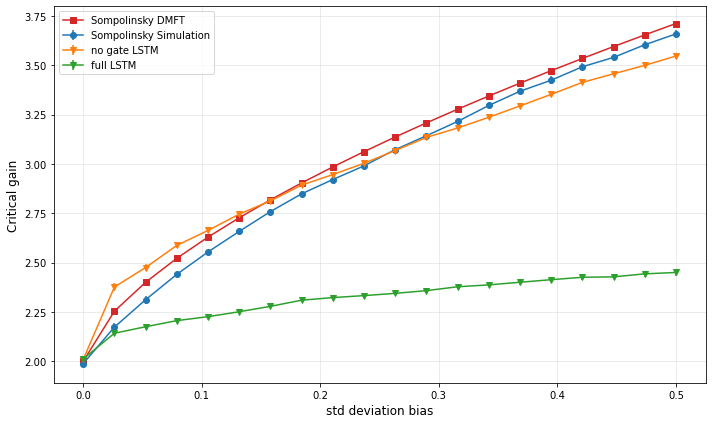

In [89]:
plt.figure(figsize=(10, 6))
plt.errorbar(sigma_b_values, g_c_empirical, yerr = err, marker = 'o', label='Sompolinsky Simulation', markersize=6)
plt.errorbar(sigma_b_values, g_c_no_gate, yerr = err_no_gate, marker = 'v', label = "no gate LSTM", markersize = 6)
plt.errorbar(sigma_b_values, g_c_full_lstm, yerr = err_full, marker = 'v', label = "full LSTM", markersize = 6)
plt.plot(sigma_b_values, g_theory, 's-', label='Sompolinsky DMFT', markersize=6)
plt.xlabel("std deviation bias", fontsize=12)
plt.ylabel("Critical gain", fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

In [80]:
np.savez('sompo_theory.npz', sigma_b=sigma_b_values, g_c=g_theory)